本仓库实现了一个插值算法的demo，在插值曲线平滑的前提下保证了相邻节点之间的曲线单调。

In [107]:
# 导入模块
import matplotlib.pyplot as plt
import numpy as np
import bisect

先输入所有节点的坐标

$p_i = (x_i, y_i), i \in \mathbb{N}, i < n$，表示共有$n$个节点，第$i$个节点的坐标为$(x_i,y_i)$；

且当 $a < b$ 时，有 $x_a < x_b $，换句话说就是$x_i$互不相等且从小到大排序。

In [108]:
# 可以在这里更改点的坐标
points = [
        (0.0,6.8),
        (2.0,0.8),
        (2.8,3.3),
        (4.0,3.0),
        (5.2,2.0),
        (6,0.0),
    ]
p=np.array(sorted(points,key=lambda x:x[0]))

x = p[:,0]
y = p[:,1]

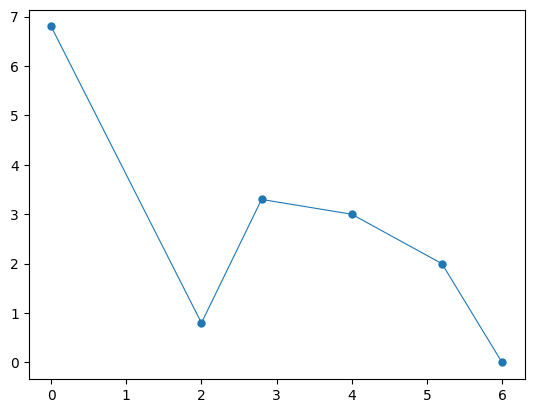

In [109]:
input_x = np.linspace(-1,8.2,1000)

plt.plot(x,y,linewidth=0.8)
plt.scatter(x,y,linewidth=0.0)
plt.show()

## 1. 计算曲线在节点上的斜率

为了保证节点分割出的每一段区间都单调，需要对每个点的斜率进行限制。

设最终的曲线为$y=f(x)$，假如一段区间$[x_i, x_{i+1}]$单调，那么必然满足$f(m)\le 0 或者 f(m) \ge 0, m \in [x_i, x_{i+1}]$，进而得出$ f(x_i) \times f(x_{i+1}) \ge 0$。换句话说，每段区间左右节点的斜率同号，或者至少有一个为0。

### 1.1 情况1：节点左右区间单调性相同

为了让曲线更平滑，该节点的斜率应当介于节点左右区间的斜率之间。而且，该节点越靠近左边，斜率应当更接近于左边节点的斜率；节点靠近右边的节点时同理。

那么可以定义为：节点左右区间的斜率的加权调和平均$m_{i}=\frac{1}{w_l \cdot \frac{x_i-x_{i-1}}{y_{i}-y_{i-1}} + w_r\cdot \frac{x_{i+1}-x_{i}}{y_{i+1}-y_{i}}}$，

权重为左右区间长度的占比$w_l = \frac{x_i-x_{i-1}}{x_{i+1}-x_{i-1}}, w_r = \frac{x_{i+1}-x_{i}}{x_{i+1}-x_{i-1}}$


In [110]:
delta_x = x[1:] - x[:-1]
delta_x_2 = delta_x[1:] + delta_x[:-1]
delta_y = y[1:] - y[:-1]
w_l = delta_x[:-1]/delta_x_2
w_r = delta_x[1:]/delta_x_2
rgrad = delta_x/delta_y # 需要支持除以0的时候为inf，否则需要单独处理
m = 1/(w_l*rgrad[:-1]+w_r*rgrad[1:])

m

array([-6.81818182, -0.44014085, -0.38461538, -1.13636364])

### 1.2 情况2：节点左右区间单调性不同

此节点的斜率只能为0。

In [111]:
m[rgrad[:-1]*rgrad[1:]<0]=0
m

array([ 0.        ,  0.        , -0.38461538, -1.13636364])

### 1.3 情况3：边缘的两个节点

这两个节点只和一个区间相邻，直接使用那个区间的斜率即可。

In [112]:
tmp = m
tmp = np.insert(tmp,0,1/rgrad[0])
tmp = np.append(tmp,1/rgrad[-1])
tmp

array([-3.        ,  0.        ,  0.        , -0.38461538, -1.13636364,
       -2.5       ])

In [113]:
m = tmp

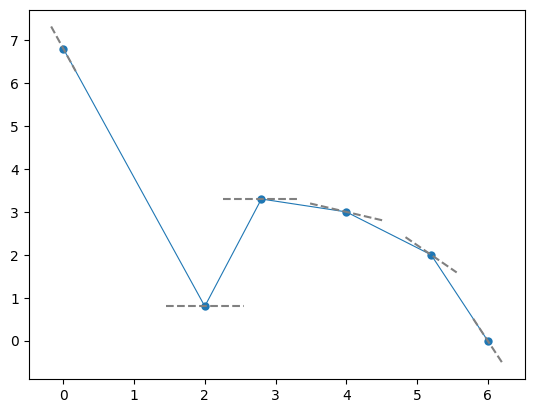

In [124]:
plt.plot(x,y,linewidth=0.8)
plt.scatter(x,y,linewidth=0.0)

for x_,y_,m_ in zip(x,y,m):
    length = np.sqrt(0.3/(1+m_**2))
    input = np.linspace(x_-length,x_+length,10)
    output = m_*(input-x_)+y_
    plt.plot(input,output,linestyle='--',color='grey')

plt.show()

# 2. 使用基函数进行插值

构造插值基函数的过程略过，感兴趣的可以参考：https://zhuanlan.zhihu.com/p/616188127



In [114]:
def base_func(x,x0,x1,x1_sub_x0,y0,y1,m0,m1):
    x_sub_x0 = x - x0
    x_sub_x1 = x - x1
    l0 = x_sub_x1/(-x1_sub_x0)
    l1 = x_sub_x0/x1_sub_x0
    l0_square = l0**2
    l1_square = l1**2
    
    h0 = (1+2*l1)*l0_square
    h1 = (1+2*l0)*l1_square
    g0 = x_sub_x0*l0_square
    g1 = x_sub_x1*l1_square
    
    return y0*h0+y1*h1+m0*g0+m1*g1

def func(x,xs,ys,ms):
    index = bisect.bisect_left(xs,x)
    if index-1<0:
        return ys[0]
    if index>=len(xs):
        return ys[-1]
    if xs[index]==x:
        return ys[index]
    return base_func(x,xs[index-1],xs[index],xs[index]-xs[index-1],ys[index-1],ys[index],ms[index-1],ms[index])

In [115]:
func(1,x,y,m)

3.05

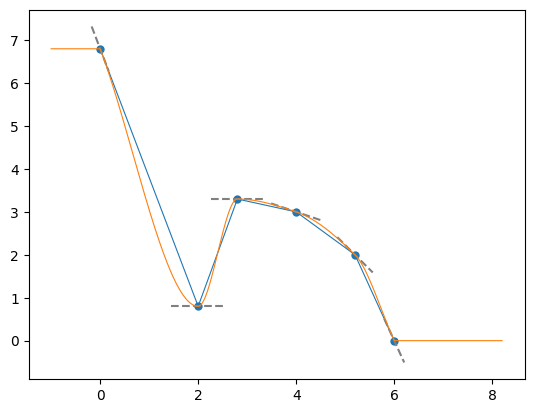

In [126]:
plt.plot(x,y,linewidth=0.8)
plt.scatter(x,y,linewidth=0.0)

for x_,y_,m_ in zip(x,y,m):
    length = np.sqrt(0.3/(1+m_**2))
    input = np.linspace(x_-length,x_+length,10)
    output = m_*(input-x_)+y_
    plt.plot(input,output,linestyle='--',color='grey')
    
input_x = np.linspace(-1,8.2,1000)
predict_y = [func(i,x,y,m) for i in input_x]
plt.plot(input_x,predict_y,linewidth=0.8)

plt.show()